In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from yahoo_fin import stock_info as si

class YahooStockData :
	def __init__(
			self , company , from_date , to_date , save_folder = "charts" ,
			result_folder = "results" , interval = '1d' ,
			stock_df = None
			) :
		self.__ticker = company
		self.__start_date = from_date
		self.__end_date = to_date
		self.interval = interval
		self.__result_folder = f"results/{result_folder}"
		self.__stock_df = stock_df
		self.__save_chart_folder = f"{self.__result_folder}/{save_folder}"
		self.__create_folder( self.__save_chart_folder )
	
	def __create_folder( self , folder ) :
		if not os.path.exists( folder ) :
			os.makedirs( folder )
	
	def get_stock_data( self ) :
		__stock_data = si.get_data(
			self.__ticker , start_date = self.__start_date ,
			end_date = self.__end_date ,
			interval = self.interval
			)
		self.__stock_df = pd.DataFrame( __stock_data.to_records( ) ).rename(
			columns = { 'index' : 'date' }
			)
		self.__stock_df = self.__stock_df.set_index( "date" )
		self.__stock_df.sort_index( ascending = True )
		return self.__stock_df
	
	def plot_stock_data(
			self , column = 'adjclose' , style = 'seaborn-dark' ,
			figsize = (10 , 15)
			) :
		if self.__stock_df is None :
			self.get_stock_data( )
		plt.style.use( style )
		self.__stock_df[ column ].plot( cmap = "viridis" , figsize = figsize )
		plt.grid( )
		file_path = os.path.join(
			self.__save_chart_folder , f'{self.__ticker}_stock_data_.png'
			)
		plt.savefig( file_path )
		plt.show( )
		plt.close( )
	
	def save_stock_data_as_pkl( self , file_name , folder = "data_sets" ) :
		file_path = f"{folder}/{file_name}"
		if self.__stock_df is None :
			self.get_stock_data( )
		
		if not os.path.exists( os.path.dirname( file_path ) ) :
			os.mkdir( os.path.dirname( file_path ) )
		
		self.__stock_df.to_pickle( file_path )
		return file_path
	
	def load_stock_data_from_pkl( self , file_path ) :
		self.__stock_df = pd.read_pickle( file_path )
		return self.__stock_df


In [2]:
import numpy as np

class StockDataPreprocessor :
	def __init__(
			self , stock_history_length = 50 , split_ratio = 0.8 ,
			normalise_stock_data = True
			) :
		self.__stock_history_length = stock_history_length
		self.__normalise_stock_data = normalise_stock_data
		self.__split_ratio = split_ratio
	
	def __normalise_data( self , data ) :
		normalised_data = [ ]
		for window in data :
			normalised_window = [ ((float( p ) / float( window[ 0 ] )) - 1) for
			                      p in window ]
			normalised_data.append( normalised_window )
		return normalised_data
	
	def __train_test_split( self , data_to_split ) :
		split_index = int( len( data_to_split ) * self.__split_ratio )
		train_data = data_to_split[ :split_index ]
		test_data = data_to_split[ split_index : ]
		return train_data , test_data
	
	def __extract_y_from_data( self , data ) :
		data = np.array( data )
		inp = data[ : , :-1 ]
		out = data[ : , -1 ]
		inp = np.reshape( inp , (inp.shape[ 0 ] , inp.shape[ 1 ] , 1) )
		return inp , out
	
	def prepare_data( self , data ) :
		history_length = self.__stock_history_length + 1
		__nomalise_data = [ ]
		for index in range( len( data ) - history_length ) :
			__nomalise_data.append( data[ index : index + history_length ] )
		
		if self.__normalise_stock_data :
			__nomalise_data = self.__normalise_data( __nomalise_data )
		
		train_data , test_data = self.__train_test_split( __nomalise_data )
		x_train , y_train = self.__extract_y_from_data( train_data )
		x_test , y_test = self.__extract_y_from_data( test_data )
		
		return x_train , y_train , x_test , y_test


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.model_selection import train_test_split

class RandomForestPredictor :
	def __init__( self , n_estimators = 100 , random_state = 42 ) :
		self.__n_estimators = n_estimators
		self.__random_state = random_state
		self.__model = RandomForestRegressor(
			n_estimators = self.__n_estimators ,
			random_state = self.__random_state
			)
		self.__history = None
	
	def train( self , x_train , y_train ) :
		x_train , x_val , y_train , y_val = train_test_split(
			x_train , y_train , test_size = 0.2 , random_state = 42
			)
		
		x_train_2d = x_train.reshape( x_train.shape[ 0 ] , -1 )
		x_val_2d = x_val.reshape( x_val.shape[ 0 ] , -1 )
		
		history = {
				'loss' : [ ] , 'val_loss' : [ ] , 'mae' : [ ] , 'mse' : [ ]
				}
		
		self.__model.fit( x_train_2d , y_train )
		__train_predictions = self.__model.predict( x_train_2d )
		__val_predictions = self.__model.predict( x_val_2d )
		
		__train_loss = mean_squared_error( y_train , __train_predictions )
		__val_loss = mean_squared_error( y_val , __val_predictions )
		__train_mae = mean_absolute_error( y_train , __train_predictions )
		
		history[ 'loss' ].append( __train_loss )
		history[ 'val_loss' ].append( __val_loss )
		history[ 'mae' ].append( __train_mae )
		history[ 'mse' ].append( __val_loss )
		
		self.__history = history
		return history , self.__model


In [4]:
from keras.layers import LSTM
from keras.layers.core import Activation , Dense , Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop

class LSTMPredictor :
	def __init__(
			self , layers , learning_rate = 0.0001 , loss = "mse" ,
			metrics = [ 'mae' , 'mse' ] , batch_size = 512 , epochs = 100 ,
			validation_split = 0.05
			) :
		self.__layers = layers
		self.__metrics = metrics
		self.__learning_rate = learning_rate
		self.__loss = loss
		self.__batch_size = batch_size
		self.__epochs = epochs
		self.__validation_split = validation_split
		self.__model = self.__build_model( )
	
	def __build_model( self ) :
		lstm_model = Sequential( )
		length = len( self.__layers )
		for layer in self.__layers :
			length -= 1
			if length != 0 :
				lstm_model.add(
					LSTM( units = layer , return_sequences = True )
					)
			else :
				lstm_model.add( LSTM( layer ) )
			
			lstm_model.add( Dropout( 0.2 ) )
		
		lstm_model.add( Dense( units = 1 ) )
		lstm_model.add( Activation( "linear" ) )
		
		optimizer = RMSprop( self.__learning_rate )
		
		lstm_model.compile(
			loss = self.__loss , optimizer = optimizer ,
			metrics = self.__metrics
			)
		return lstm_model
	
	def train( self , x_train , y_train ) :
		history = self.__model.fit(
				x_train ,
				y_train ,
				batch_size = self.__batch_size ,
				epochs = self.__epochs ,
				validation_split = self.__validation_split
				)
		return history , self.__model


In [5]:
from keras.layers import GRU
from keras.layers.core import Activation , Dense , Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop

class GRUPredictor :
	def __init__(
			self , layers , learning_rate = 0.0001 , loss = "mse" ,
			metrics = [ 'mae' , 'mse' ] , batch_size = 512 , epochs = 100 ,
			validation_split = 0.05
			) :
		self.__layers = layers
		self.__metrics = metrics
		self.__learning_rate = learning_rate
		self.__loss = loss
		self.__batch_size = batch_size
		self.__epochs = epochs
		self.__validation_split = validation_split
		self.__model = self.__build_model( )
	
	def __build_model( self ) :
		gru_model = Sequential( )
		
		length = len( self.__layers )
		for layer in self.__layers :
			length -= 1
			if length != 0 :
				gru_model.add( GRU( units = layer , return_sequences = True ) )
			else :
				gru_model.add( GRU( layer ) )
			
			gru_model.add( Dropout( 0.2 ) )
		
		gru_model.add( Dense( units = 1 ) )
		gru_model.add( Activation( "linear" ) )
		
		optimizer = RMSprop( self.__learning_rate )
		
		gru_model.compile(
			loss = self.__loss , optimizer = optimizer ,
			metrics = self.__metrics
			)
		return gru_model
	
	def train( self , x_train , y_train ) :
		history = self.__model.fit(
				x_train ,
				y_train ,
				batch_size = self.__batch_size ,
				epochs = self.__epochs ,
				validation_split = self.__validation_split
				)
		return history , self.__model


In [6]:
from keras.layers import Conv1D , Flatten , MaxPooling1D
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

class CNNPredictor :
	def __init__(
			self , layers , input_shape , learning_rate = 0.0001 ,
			filters = 64 , kernel_size = 3 , pool_size = 2 , epochs = 100 ,
			loss = "mse" ,
			metrics = [ 'mae' , 'mse' ]
			) :
		self.__layers = layers
		self.__filters = filters
		self.__kernel_size = kernel_size
		self.__pool_size = pool_size
		self.__input_shape = input_shape
		self.__epochs = epochs
		self.__loss = loss
		self.__metrics = metrics
		self.__learning_rate = learning_rate
		self.__model = self.__build_model( )
	
	def __build_model( self ) :
		cnn_model = Sequential( )
		
		cnn_model.add(
			Conv1D(
				filters = self.__filters , kernel_size = self.__kernel_size ,
				activation = 'relu' ,
				input_shape = self.__input_shape
				)
			)
		cnn_model.add( MaxPooling1D( pool_size = self.__pool_size ) )
		cnn_model.add( Flatten( ) )
		
		for units in self.__layers[ 1 : ] :
			cnn_model.add( Dense( units = units , activation = 'relu' ) )
		optimizer = RMSprop( self.__learning_rate )
		
		cnn_model.compile(
			optimizer = optimizer , loss = self.__loss ,
			metrics = self.__metrics
			)
		return cnn_model
	
	def train( self , x_train , y_train ) :
		history = self.__model.fit(
				x_train ,
				y_train ,
				epochs = self.__epochs ,
				validation_split = 0.05
				)
		return history , self.__model


In [7]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np

results_folder = "results"

sub_folders = [ f.path for f in os.scandir( results_folder ) if f.is_dir( ) ]

rmse_values = {
		"Random Forest" : [ ] , "LSTM" : [ ] , "GRU" : [ ] , "CNN" : [ ]
		}
epochs_list = [ ]
seq_lengths_list = [ ]

def get_metrics( ) :
	for sub_folder in sub_folders :
		for file in os.listdir( sub_folder ) :
			if file.endswith( ".json" ) :
				results_file = os.path.join( sub_folder , file )
				with open( results_file , "r" ) as f :
					results_data = json.load( f )
				
				for model in [ "Random Forest" , "LSTM" , "GRU" , "CNN" ] :
					rmse_values[ model ].append(
							results_data[ "all_models" ][ "rmse" ][ model ]
							)
				
				epochs = results_data[ "train_metadata" ][ "epochs" ]
				seq_len = results_data[ "train_metadata" ][ "seq_len" ]
				epochs_list.append( epochs )
				seq_lengths_list.append( seq_len )

def plot_and_save_metric_and_save( ) :
	bar_width = 0.15
	x = np.arange( len( epochs_list ) )
	fig , ax = plt.subplots( figsize = (12 , 6) )
	ax.bar(
			x - 3 * bar_width / 2 , rmse_values[ "Random Forest" ] ,
			bar_width ,
			label = "Random Forest"
			)
	ax.bar(
			x - bar_width / 2 , rmse_values[ "LSTM" ] , bar_width ,
			label = "LSTM"
			)
	ax.bar(
			x + bar_width / 2 , rmse_values[ "GRU" ] , bar_width , label =
			"GRU"
			)
	ax.bar(
			x + 3 * bar_width / 2 , rmse_values[ "CNN" ] , bar_width , label =
			"CNN"
			)
	ax.set_ylabel( "RMSE" )
	ax.set_title(
			"RMSE Comparison for Different Models, Epochs, and Sequence "
			"Lengths"
			)
	ax.set_xticks( x )
	ax.set_xticklabels(
			[ f"E{e}, S{s}" for e , s in
			  zip( epochs_list , seq_lengths_list ) ] , rotation = 45
			)
	ax.legend( )
	plt.savefig( "rmse_comparison_chart_epochs_seq_lengths_bar.png" )
	plt.show( )

def get_final_good_model( ) :
	global best_worst_rmse
	best_worst_rmse = {
			"Random Forest" : { "best" : float( "inf" ) } ,
			"LSTM"          : { "best" : float( "inf" ) , "worst" : 0 } ,
			"GRU"           : { "best" : float( "inf" ) , "worst" : 0 } ,
			"CNN"           : { "best" : float( "inf" ) , "worst" : 0 } ,
			}
	
	for model in [ "Random Forest" , "LSTM" , "GRU" , "CNN" ] :
		for i , rmse_value in enumerate( rmse_values[ model ] ) :
			if model == "Random Forest" :
				best_worst_rmse[ model ][ "best" ] = rmse_value
			else :
				if rmse_value < best_worst_rmse[ model ][ "best" ] :
					best_worst_rmse[ model ][ "best" ] = rmse_value
					best_worst_rmse[ model ][ "best_seq_len" ] = \
						seq_lengths_list[ i ]
					best_worst_rmse[ model ][ "best_epochs" ] = epochs_list[
						i ]
				if rmse_value > best_worst_rmse[ model ][ "worst" ] :
					best_worst_rmse[ model ][ "worst" ] = rmse_value
					best_worst_rmse[ model ][ "worst_seq_len" ] = \
						seq_lengths_list[ i ]
					best_worst_rmse[ model ][ "worst_epochs" ] = epochs_list[
						i ]
	
	final_best_model = min(
			best_worst_rmse , key = lambda x : best_worst_rmse[ x ][ "best" ]
			)
	best_worst_rmse[ "final_best_model" ] = final_best_model
	
	with open( "best_worst_rmse_final_good_model.json" , "w" ) as f :
		json.dump( best_worst_rmse , f , indent = 2 )


In [8]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error , mean_squared_error

class PerformanceUtil :
	def __init__(
			self , histories , all_predictions , y_test , metadata ,
			save_folder = "charts" , result_folder = "" ,
			model_folder = 'models'
			) :
		self.__histories = histories
		self.__all_predictions = all_predictions
		self.__y_test = y_test
		self.__result_folder = f"results/{result_folder}"
		self.__save_chart_folder = f"{self.__result_folder}/{save_folder}"
		self.__save_model_folder = f"{self.__result_folder}/{model_folder}"
		self.__metadata = metadata
		self.__error_metrics = None
		self.__create_folder( self.__save_model_folder )
		self.__create_folder( self.__save_chart_folder )
	
	def __create_folder( self , folder ) :
		if not os.path.exists( folder ) :
			os.makedirs( folder )
	
	def __root_absolute_squared_error(
			self , y_true , y_pred , threshold = 0.5
			) :
		return np.sqrt( mean_absolute_error( y_true , y_pred ) )
	
	def __root_mean_squared_error( self , y_true , y_pred ) :
		return np.sqrt( mean_squared_error( y_true , y_pred ) )
	
	def __get_error_metrics( self , y_test ) :
		performance_metrics = [ 'rmse' , 'mae' ]
		self.__error_metrics = { metric : { } for metric in
		                         performance_metrics }
		for model_name , predictions in self.__all_predictions.items( ) :
			self.__error_metrics[ 'rmse' ][
				model_name ] = self.__root_mean_squared_error(
				y_test , predictions
				)
			self.__error_metrics[ 'mae' ][
				model_name ] = self.__root_absolute_squared_error(
				y_test , predictions
				)
	
	def __write_result( self , best_model_name ) :
		data = {
				"train_metadata" : self.__metadata ,
				"all_models"     : self.__error_metrics ,
				"best_model"     : best_model_name
				}
		model_file_path = os.path.join(
			self.__result_folder , "model_metrics_with_best_models.json"
			)
		
		with open( model_file_path , "w" ) as file :
			json.dump( data , file , indent = 4 )
	
	def save_models( self , models ) :
		for model_name , model in models.items( ) :
			model_file_path = os.path.join(
				self.__save_model_folder , f'{model_name}_model.pkl'
				)
			with open( model_file_path , 'wb' ) as f :
				pickle.dump( model , f )
	
	def print_and_writebest_model_based_on_rmse( self ) :
		best_model_name = min(
				self.__error_metrics[ 'rmse' ] ,
				key = self.__error_metrics[ 'rmse' ].get
				)
		best_rmse = self.__error_metrics[ 'rmse' ][ best_model_name ]
		print( "All Models and Root Mean Squared Error:" )
		for model_name , rmse in self.__error_metrics[ 'rmse' ].items( ) :
			print( f"\t{model_name}'s RMSE is {rmse:.4f}" )
		
		print(
			f"The best model is {best_model_name} with an RMSE of "
			f"{best_rmse:.4f}"
			)
		self.__write_result( best_model_name )
	
	def plot_loss_curves( self ) :
		num_models = len( self.__histories )
		fig , axs = plt.subplots(
			num_models , 1 , figsize = (10 , num_models * 5) ,
			constrained_layout = True
			)
		
		for i , model_history in enumerate( self.__histories ) :
			for model_name , history in model_history.items( ) :
				axs[ i ].plot(
						history.history[ 'loss' ] , label = 'Training Loss'
						)
				axs[ i ].plot(
						history.history[ 'val_loss' ] ,
						label = 'Validation Loss'
						)
				axs[ i ].plot( history.history[ 'mse' ] , label = "MSE" )
				axs[ i ].plot( history.history[ 'mae' ] , label = "MAE" )
				axs[ i ].set_title( f'Metrics of {model_name}' )
				axs[ i ].set_xlabel( 'Epoch' )
				axs[ i ].set_ylabel( 'Loss' )
				axs[ i ].legend( loc = 'upper right' )
		file_path = os.path.join(
			self.__save_chart_folder , 'all_model_loss_curves.png'
			)
		plt.savefig( file_path )
		plt.show( )
		plt.close( )
	
	def plot_all_models_performance( self ) :
		for model_history in self.__histories :
			for model_name , history in model_history.items( ) :
				plt.plot(
						history.history[ 'val_loss' ] ,
						label = f"{model_name} Validation"
						)
		plt.title( 'All Models Validation Loss' )
		plt.xlabel( 'Epoch' )
		plt.ylabel( 'Loss' )
		plt.legend( loc = 'upper right' )
		file_path = os.path.join(
			self.__save_chart_folder , 'all_model_validation_loss_curves.png'
			)
		plt.savefig( file_path )
		plt.show( )
		plt.close( )
	
	def plot_all_predictions( self ) :
		plt.plot( self.__y_test , label = 'True Values' )
		for model_name , predictions in self.__all_predictions.items( ) :
			plt.plot( predictions , label = f'{model_name} Predictions' )
		plt.title( 'All Models Predictions vs True Values' )
		plt.legend( loc = 'upper right' )
		plt.show( )
		plt.close( )
		
		n_models = len( self.__all_predictions )
		fig , axes = plt.subplots(
			n_models , 1 , figsize = (10 , n_models * 5) , sharex = True
			)
		
		for i , (model_name , predictions) in enumerate(
				self.__all_predictions.items( )
				) :
			axes[ i ].plot(
				self.__y_test , label = 'True Values' , alpha = 0.6
				)
			axes[ i ].plot(
				predictions , label = f'{model_name} Predictions' , alpha = 0.6
				)
			axes[ i ].set_title( f'{model_name} Predictions vs True Values' )
			axes[ i ].legend( loc = 'upper right' )
		
		plt.xlabel( 'Time Steps' )
		plt.tight_layout( )
		file_path = os.path.join(
			self.__save_chart_folder ,
			'all_model_predictions_vs_true_values.png'
			)
		plt.savefig( file_path )
		plt.show( )
		plt.close( )
	
	def plot_error_metric_comparison( self ) :
		self.__get_error_metrics( self.__y_test )
		
		fig , axs = plt.subplots( 1 , 2 , figsize = (15 , 5) )
		
		for idx , (metric , model_results) in enumerate(
				self.__error_metrics.items( )
				) :
			model_names = list( model_results.keys( ) )
			metric_values = list( model_results.values( ) )
			
			axs[ idx ].bar( model_names , metric_values )
			axs[ idx ].set_title( f'{metric.upper( )} Comparison' )
			axs[ idx ].set_xlabel( 'Models' )
			axs[ idx ].set_ylabel( metric.upper( ) )
		
		file_path = os.path.join(
			self.__save_chart_folder , 'all_model_error_metric_comparison.png'
			)
		plt.savefig( file_path )
		plt.show( )
		plt.close( )


In [10]:
def train_and_evaluate_models(
		x_train , y_train , x_test , y_test , layers , epochs
		) :
	model_histories = [ ]
	
	rf_predictor = RandomForestPredictor( )
	rf_history , rf_model = rf_predictor.train( x_train , y_train )
	
	lstm_predictor = LSTMPredictor( layers , epochs = epochs )
	lstm_history , lstm_model = lstm_predictor.train( x_train , y_train )
	model_histories.append( { "LSTM" : lstm_history } )
	
	gru_predictor = GRUPredictor( layers , epochs = epochs )
	gru_history , gru_model = gru_predictor.train( x_train , y_train )
	model_histories.append( { "GRU" : gru_history } )
	
	cnn_predictor = CNNPredictor(
		layers , input_shape = (x_train.shape[ 1 ] , 1) , epochs = epochs
		)
	cnn_history , cnn_model = cnn_predictor.train( x_train , y_train )
	model_histories.append( { "CNN" : cnn_history } )
	
	all_predictions = {
			"Random Forest" : rf_model.predict(
				x_test.reshape( x_test.shape[ 0 ] , -1 )
				) ,
			"LSTM"          : lstm_model.predict( x_test ) ,
			"GRU"           : gru_model.predict( x_test ) ,
			"CNN"           : cnn_model.predict( x_test )
			}
	
	all_models = {
			"Random Forest" : rf_model ,
			"LSTM"          : lstm_model ,
			"GRU"           : gru_model ,
			"CNN"           : cnn_model
			}
	
	return model_histories , all_predictions , all_models

def get_and_save_yahoo_stock_data(
		ticker , start_date , end_date , result_folder , file_name
		) :
	yahoo_stock_data = YahooStockData(
		ticker , start_date , end_date , result_folder = result_folder
		)
	stock_df = yahoo_stock_data.get_stock_data( )
	yahoo_stock_data.plot_stock_data( )
	file_path = yahoo_stock_data.save_stock_data_as_pkl( file_name )
	stock_df_loaded = yahoo_stock_data.load_stock_data_from_pkl( file_path )
	return stock_df_loaded

def main( ) :
	start_date = '1875-02-01 00:00:00'
	end_date = '2023-04-01 23:59:59'
	ticker = "AAPL"
	file_name = "apple.pkl"
	
	seq_len = 15
	epochs = 200
	layers = [ seq_len , 50 , 100 , 1 ]
	
	current_time = datetime.datetime.now( )
	time_stamp = current_time.strftime( "%d_%H-%M-%S" )
	
	result_folder = f"Ticker_{ticker}_{time_stamp}_layers" + "_".join(
			[ str( i ) for i in layers ]
			) + f"_epochs_{epochs}"
	
	stock_df_loaded = get_and_save_yahoo_stock_data(
		ticker , start_date , end_date , result_folder , file_name
		)
	
	data_preprocessing = StockDataPreprocessor( seq_len )
	stock_data = stock_df_loaded[ 'adjclose' ].values
	x_train , y_train , x_test , y_test = data_preprocessing.prepare_data(
		stock_data
		)
	
	model_histories , all_predictions , all_models = train_and_evaluate_models(
		x_train , y_train , x_test , y_test , layers ,
		epochs
		)
	
	metadata = {
			"trained_at" : time_stamp ,
			"seq_len"    : seq_len ,
			"epochs"     : epochs ,
			"layers"     : layers ,
			"data"       : {
					"ticker" : ticker , "start_date" : start_date ,
					"end_date" : end_date ,
					"count" : {
							"x_train" : len( x_train ) ,
							"y_train" : len( y_train ) ,
							"x_test"  : len( x_test ) ,
							"y_test"  : len( y_test )
							}
					}
			}
	
	performance_util = PerformanceUtil(
		model_histories , all_predictions , y_test ,
		result_folder = result_folder ,
		metadata = metadata
		)
	performance_util.save_models( all_models )
	performance_util.plot_loss_curves( )
	performance_util.plot_all_models_performance( )
	performance_util.plot_all_predictions( )
	performance_util.plot_error_metric_comparison( )
	performance_util.print_and_writebest_model_based_on_rmse( )


/var/folders/ms/2f084nvx1n5b5wq69jt8j3cc0000gn/T/ipykernel_86416/49938427.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use( style )


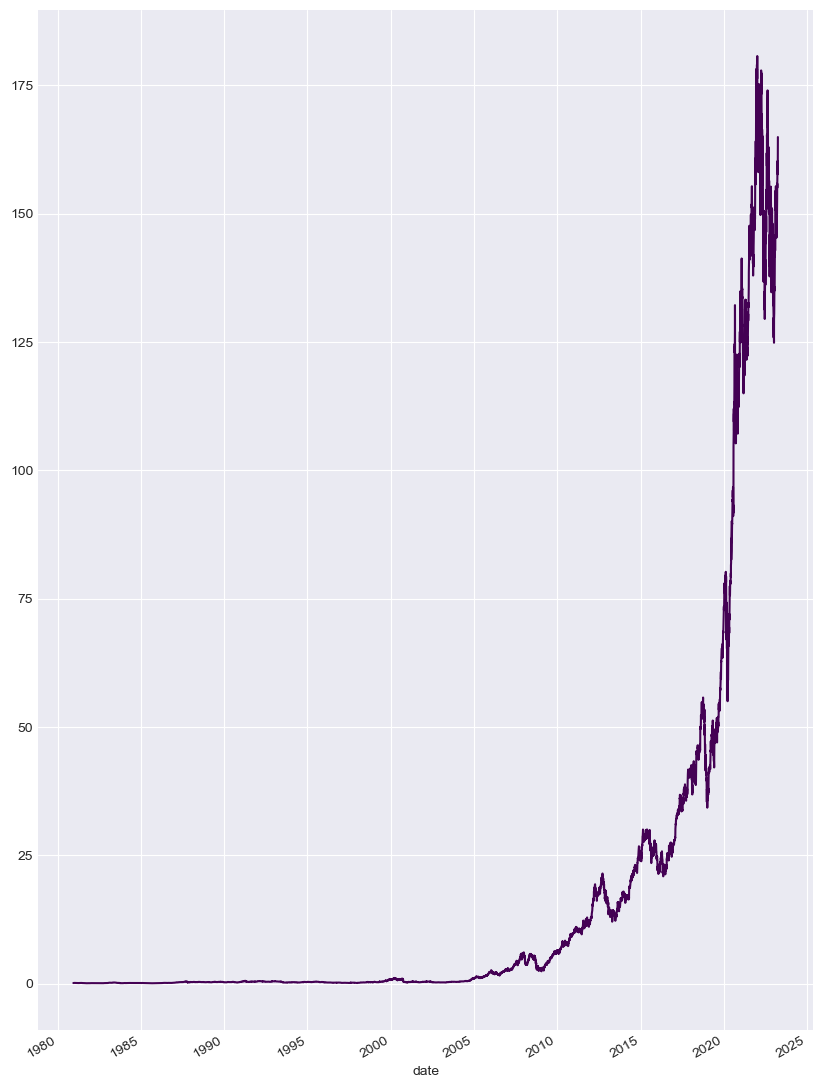

Metal device set to: Apple M1 Max
Epoch 1/200


2023-05-09 18:19:51.644425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 18:19:51.644543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-09 18:19:51.740737: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-09 18:19:53.717652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:19:54.015720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:19:54.134512: I tensorflow/core/grappler/o

16/16 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.0873 - mse: 0.0134

2023-05-09 18:19:56.568293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:19:56.667115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:19:56.727730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 5s 122ms/step - loss: 0.0134 - mae: 0.0873 - mse: 0.0134 - val_loss: 0.0029 - val_mae: 0.0417 - val_mse: 0.0029
Epoch 2/200


2023-05-09 18:19:56.794079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:19:56.884656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 45ms/step - loss: 0.0121 - mae: 0.0832 - mse: 0.0121 - val_loss: 0.0026 - val_mae: 0.0397 - val_mse: 0.0026
Epoch 3/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0109 - mae: 0.0787 - mse: 0.0109 - val_loss: 0.0023 - val_mae: 0.0374 - val_mse: 0.0023
Epoch 4/200
16/16 [==============================] - 1s 44ms/step - loss: 0.0097 - mae: 0.0740 - mse: 0.0097 - val_loss: 0.0022 - val_mae: 0.0355 - val_mse: 0.0022
Epoch 5/200
16/16 [==============================] - 1s 45ms/step - loss: 0.0090 - mae: 0.0706 - mse: 0.0090 - val_loss: 0.0020 - val_mae: 0.0351 - val_mse: 0.0020
Epoch 6/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0087 - mae: 0.0690 - mse: 0.0087 - val_loss: 0.0020 - val_mae: 0.0348 - val_mse: 0.0020
Epoch 7/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0084 - mae: 0.0682 - mse: 0.0084 - val_loss: 0.0019 - val_mae: 0.0345 - val_mse: 0.0019
Epoch 8/200
16/16 [=========

16/16 [==============================] - 1s 39ms/step - loss: 0.0050 - mae: 0.0486 - mse: 0.0050 - val_loss: 7.7005e-04 - val_mae: 0.0207 - val_mse: 7.7005e-04
Epoch 52/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0049 - mae: 0.0489 - mse: 0.0049 - val_loss: 7.6227e-04 - val_mae: 0.0205 - val_mse: 7.6227e-04
Epoch 53/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0050 - mae: 0.0485 - mse: 0.0050 - val_loss: 7.3821e-04 - val_mae: 0.0203 - val_mse: 7.3821e-04
Epoch 54/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0049 - mae: 0.0484 - mse: 0.0049 - val_loss: 7.2992e-04 - val_mae: 0.0202 - val_mse: 7.2992e-04
Epoch 55/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0050 - mae: 0.0480 - mse: 0.0050 - val_loss: 7.2690e-04 - val_mae: 0.0201 - val_mse: 7.2690e-04
Epoch 56/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0048 - mae: 0.0480 - mse: 0.0048 - val_loss: 7.0269e-04 - val_mae: 0.01

16/16 [==============================] - 1s 41ms/step - loss: 0.0043 - mae: 0.0432 - mse: 0.0043 - val_loss: 5.1234e-04 - val_mae: 0.0167 - val_mse: 5.1234e-04
Epoch 99/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0044 - mae: 0.0432 - mse: 0.0044 - val_loss: 5.0290e-04 - val_mae: 0.0165 - val_mse: 5.0290e-04
Epoch 100/200
16/16 [==============================] - 1s 40ms/step - loss: 0.0043 - mae: 0.0432 - mse: 0.0043 - val_loss: 5.0134e-04 - val_mae: 0.0165 - val_mse: 5.0134e-04
Epoch 101/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0041 - mae: 0.0427 - mse: 0.0041 - val_loss: 4.8738e-04 - val_mae: 0.0163 - val_mse: 4.8738e-04
Epoch 102/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0042 - mae: 0.0427 - mse: 0.0042 - val_loss: 4.9741e-04 - val_mae: 0.0165 - val_mse: 4.9741e-04
Epoch 103/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0045 - mae: 0.0431 - mse: 0.0045 - val_loss: 5.0834e-04 - val_mae: 

16/16 [==============================] - 1s 41ms/step - loss: 0.0042 - mae: 0.0406 - mse: 0.0042 - val_loss: 4.0671e-04 - val_mae: 0.0149 - val_mse: 4.0671e-04
Epoch 146/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0040 - mae: 0.0402 - mse: 0.0040 - val_loss: 4.2407e-04 - val_mae: 0.0151 - val_mse: 4.2407e-04
Epoch 147/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0041 - mae: 0.0403 - mse: 0.0041 - val_loss: 3.8897e-04 - val_mae: 0.0145 - val_mse: 3.8897e-04
Epoch 148/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0039 - mae: 0.0396 - mse: 0.0039 - val_loss: 3.8152e-04 - val_mae: 0.0143 - val_mse: 3.8152e-04
Epoch 149/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0040 - mae: 0.0399 - mse: 0.0040 - val_loss: 4.0871e-04 - val_mae: 0.0148 - val_mse: 4.0871e-04
Epoch 150/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0038 - mae: 0.0394 - mse: 0.0038 - val_loss: 3.8049e-04 - val_mae:

16/16 [==============================] - 1s 40ms/step - loss: 0.0039 - mae: 0.0382 - mse: 0.0039 - val_loss: 3.2529e-04 - val_mae: 0.0132 - val_mse: 3.2529e-04
Epoch 193/200
16/16 [==============================] - 1s 40ms/step - loss: 0.0037 - mae: 0.0382 - mse: 0.0037 - val_loss: 3.3470e-04 - val_mae: 0.0134 - val_mse: 3.3470e-04
Epoch 194/200
16/16 [==============================] - 1s 40ms/step - loss: 0.0036 - mae: 0.0377 - mse: 0.0036 - val_loss: 3.3858e-04 - val_mae: 0.0136 - val_mse: 3.3858e-04
Epoch 195/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0038 - mae: 0.0378 - mse: 0.0038 - val_loss: 3.3438e-04 - val_mae: 0.0134 - val_mse: 3.3438e-04
Epoch 196/200
16/16 [==============================] - 1s 39ms/step - loss: 0.0039 - mae: 0.0382 - mse: 0.0039 - val_loss: 3.4048e-04 - val_mae: 0.0135 - val_mse: 3.4048e-04
Epoch 197/200
16/16 [==============================] - 1s 40ms/step - loss: 0.0036 - mae: 0.0379 - mse: 0.0036 - val_loss: 3.5022e-04 - val_mae:

2023-05-09 18:22:07.890320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:08.159680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:08.254535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:08.339405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:08.424328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:08.558784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:08.693577: I tensorflow/core/grappler/optimizers/cust

 1/16 [>.............................] - ETA: 46s - loss: 0.0146 - mae: 0.0919 - mse: 0.0146

2023-05-09 18:22:08.999646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.0875 - mse: 0.0134

2023-05-09 18:22:10.727939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:10.813257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:10.883434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 5s 130ms/step - loss: 0.0134 - mae: 0.0875 - mse: 0.0134 - val_loss: 0.0028 - val_mae: 0.0411 - val_mse: 0.0028
Epoch 2/200


2023-05-09 18:22:10.955338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:22:11.031929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 46ms/step - loss: 0.0115 - mae: 0.0810 - mse: 0.0115 - val_loss: 0.0024 - val_mae: 0.0379 - val_mse: 0.0024
Epoch 3/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0100 - mae: 0.0752 - mse: 0.0100 - val_loss: 0.0020 - val_mae: 0.0347 - val_mse: 0.0020
Epoch 4/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0086 - mae: 0.0695 - mse: 0.0086 - val_loss: 0.0017 - val_mae: 0.0316 - val_mse: 0.0017
Epoch 5/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0074 - mae: 0.0637 - mse: 0.0074 - val_loss: 0.0015 - val_mae: 0.0290 - val_mse: 0.0015
Epoch 6/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0067 - mae: 0.0592 - mse: 0.0067 - val_loss: 0.0013 - val_mae: 0.0274 - val_mse: 0.0013
Epoch 7/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0062 - mae: 0.0570 - mse: 0.0062 - val_loss: 0.0012 - val_mae: 0.0270 - val_mse: 0.0012
Epoch 8/200
16/16 [=========

Epoch 52/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0072 - mae: 0.0624 - mse: 0.0072 - val_loss: 0.0015 - val_mae: 0.0302 - val_mse: 0.0015
Epoch 53/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0073 - mae: 0.0623 - mse: 0.0073 - val_loss: 0.0015 - val_mae: 0.0298 - val_mse: 0.0015
Epoch 54/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0074 - mae: 0.0629 - mse: 0.0074 - val_loss: 0.0015 - val_mae: 0.0296 - val_mse: 0.0015
Epoch 55/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0072 - mae: 0.0623 - mse: 0.0072 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 56/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0071 - mae: 0.0619 - mse: 0.0071 - val_loss: 0.0014 - val_mae: 0.0293 - val_mse: 0.0014
Epoch 57/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0071 - mae: 0.0616 - mse: 0.0071 - val_loss: 0.0014 - val_mae: 0.0290 - val_mse: 0.0014
Epoch 58/2

16/16 [==============================] - 1s 44ms/step - loss: 0.0052 - mae: 0.0493 - mse: 0.0052 - val_loss: 7.6526e-04 - val_mae: 0.0207 - val_mse: 7.6526e-04
Epoch 101/200
16/16 [==============================] - 1s 48ms/step - loss: 0.0050 - mae: 0.0490 - mse: 0.0050 - val_loss: 7.4885e-04 - val_mae: 0.0205 - val_mse: 7.4885e-04
Epoch 102/200
16/16 [==============================] - 1s 44ms/step - loss: 0.0050 - mae: 0.0490 - mse: 0.0050 - val_loss: 7.7252e-04 - val_mae: 0.0208 - val_mse: 7.7252e-04
Epoch 103/200
16/16 [==============================] - 1s 42ms/step - loss: 0.0050 - mae: 0.0487 - mse: 0.0050 - val_loss: 7.6310e-04 - val_mae: 0.0206 - val_mse: 7.6310e-04
Epoch 104/200
16/16 [==============================] - 1s 44ms/step - loss: 0.0048 - mae: 0.0483 - mse: 0.0048 - val_loss: 7.8179e-04 - val_mae: 0.0211 - val_mse: 7.8179e-04
Epoch 105/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0047 - mae: 0.0480 - mse: 0.0047 - val_loss: 7.6483e-04 - val_mae:

16/16 [==============================] - 1s 42ms/step - loss: 0.0049 - mae: 0.0481 - mse: 0.0049 - val_loss: 7.0249e-04 - val_mae: 0.0198 - val_mse: 7.0249e-04
Epoch 148/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0047 - mae: 0.0476 - mse: 0.0047 - val_loss: 6.8814e-04 - val_mae: 0.0197 - val_mse: 6.8814e-04
Epoch 149/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0049 - mae: 0.0478 - mse: 0.0049 - val_loss: 6.8521e-04 - val_mae: 0.0196 - val_mse: 6.8521e-04
Epoch 150/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0051 - mae: 0.0489 - mse: 0.0051 - val_loss: 7.0208e-04 - val_mae: 0.0200 - val_mse: 7.0208e-04
Epoch 151/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0050 - mae: 0.0483 - mse: 0.0050 - val_loss: 7.0968e-04 - val_mae: 0.0200 - val_mse: 7.0968e-04
Epoch 152/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0047 - mae: 0.0478 - mse: 0.0047 - val_loss: 6.8023e-04 - val_mae:

16/16 [==============================] - 1s 40ms/step - loss: 0.0058 - mae: 0.0552 - mse: 0.0058 - val_loss: 4.3510e-04 - val_mae: 0.0151 - val_mse: 4.3510e-04
Epoch 195/200
16/16 [==============================] - 1s 40ms/step - loss: 0.0056 - mae: 0.0553 - mse: 0.0056 - val_loss: 4.5851e-04 - val_mae: 0.0161 - val_mse: 4.5851e-04
Epoch 196/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0061 - mae: 0.0577 - mse: 0.0061 - val_loss: 4.3285e-04 - val_mae: 0.0154 - val_mse: 4.3285e-04
Epoch 197/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0063 - mae: 0.0587 - mse: 0.0063 - val_loss: 4.4770e-04 - val_mae: 0.0153 - val_mse: 4.4770e-04
Epoch 198/200
16/16 [==============================] - 1s 41ms/step - loss: 0.0065 - mae: 0.0600 - mse: 0.0065 - val_loss: 4.3596e-04 - val_mae: 0.0156 - val_mse: 4.3596e-04
Epoch 199/200
16/16 [==============================] - 1s 43ms/step - loss: 0.0066 - mae: 0.0612 - mse: 0.0066 - val_loss: 4.4807e-04 - val_mae:

2023-05-09 18:24:27.105774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


253/253 [==============================] - 4s 12ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 2/200
  1/253 [..............................] - ETA: 2s - loss: 0.0130 - mae: 0.0883 - mse: 0.0130

2023-05-09 18:24:30.274883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 3/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 4/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 5/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 6/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 7/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 8/200
253/253 [=

253/253 [==============================] - 3s 11ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 52/200
253/253 [==============================] - 3s 11ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 53/200
253/253 [==============================] - 3s 10ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 54/200
253/253 [==============================] - 3s 10ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 55/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 56/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 57/200


253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 101/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 102/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 103/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 104/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 105/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 106/20

253/253 [==============================] - 3s 11ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 150/200
253/253 [==============================] - 3s 11ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 151/200
253/253 [==============================] - 3s 10ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 152/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 153/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 154/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 155

253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 199/200
253/253 [==============================] - 2s 9ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035
Epoch 200/200
253/253 [==============================] - 3s 10ms/step - loss: 0.0142 - mae: 0.0902 - mse: 0.0142 - val_loss: 0.0035 - val_mae: 0.0453 - val_mse: 0.0035


2023-05-09 18:32:24.332344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:32:24.421896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:32:24.494004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/67 [..............................] - ETA: 45s

2023-05-09 18:32:24.579274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:32:24.663975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 2s 16ms/step


2023-05-09 18:32:26.192911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:32:26.273908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:32:26.344204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/67 [..............................] - ETA: 49s

2023-05-09 18:32:26.426423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-09 18:32:26.506756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/67 [=======================>......] - ETA: 0s

2023-05-09 18:32:27.703537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 0s 3ms/step


INFO:tensorflow:Assets written to: ram://7e360b68-b942-4d3f-8f45-f07f955817ec/assets


INFO:tensorflow:Assets written to: ram://7e360b68-b942-4d3f-8f45-f07f955817ec/assets


INFO:tensorflow:Assets written to: ram://0174d3c0-e587-4dbd-8e92-ae9e0739a841/assets


INFO:tensorflow:Assets written to: ram://0174d3c0-e587-4dbd-8e92-ae9e0739a841/assets


INFO:tensorflow:Assets written to: ram://4d2df547-0da4-4927-8da5-514dc93ad451/assets


INFO:tensorflow:Assets written to: ram://4d2df547-0da4-4927-8da5-514dc93ad451/assets


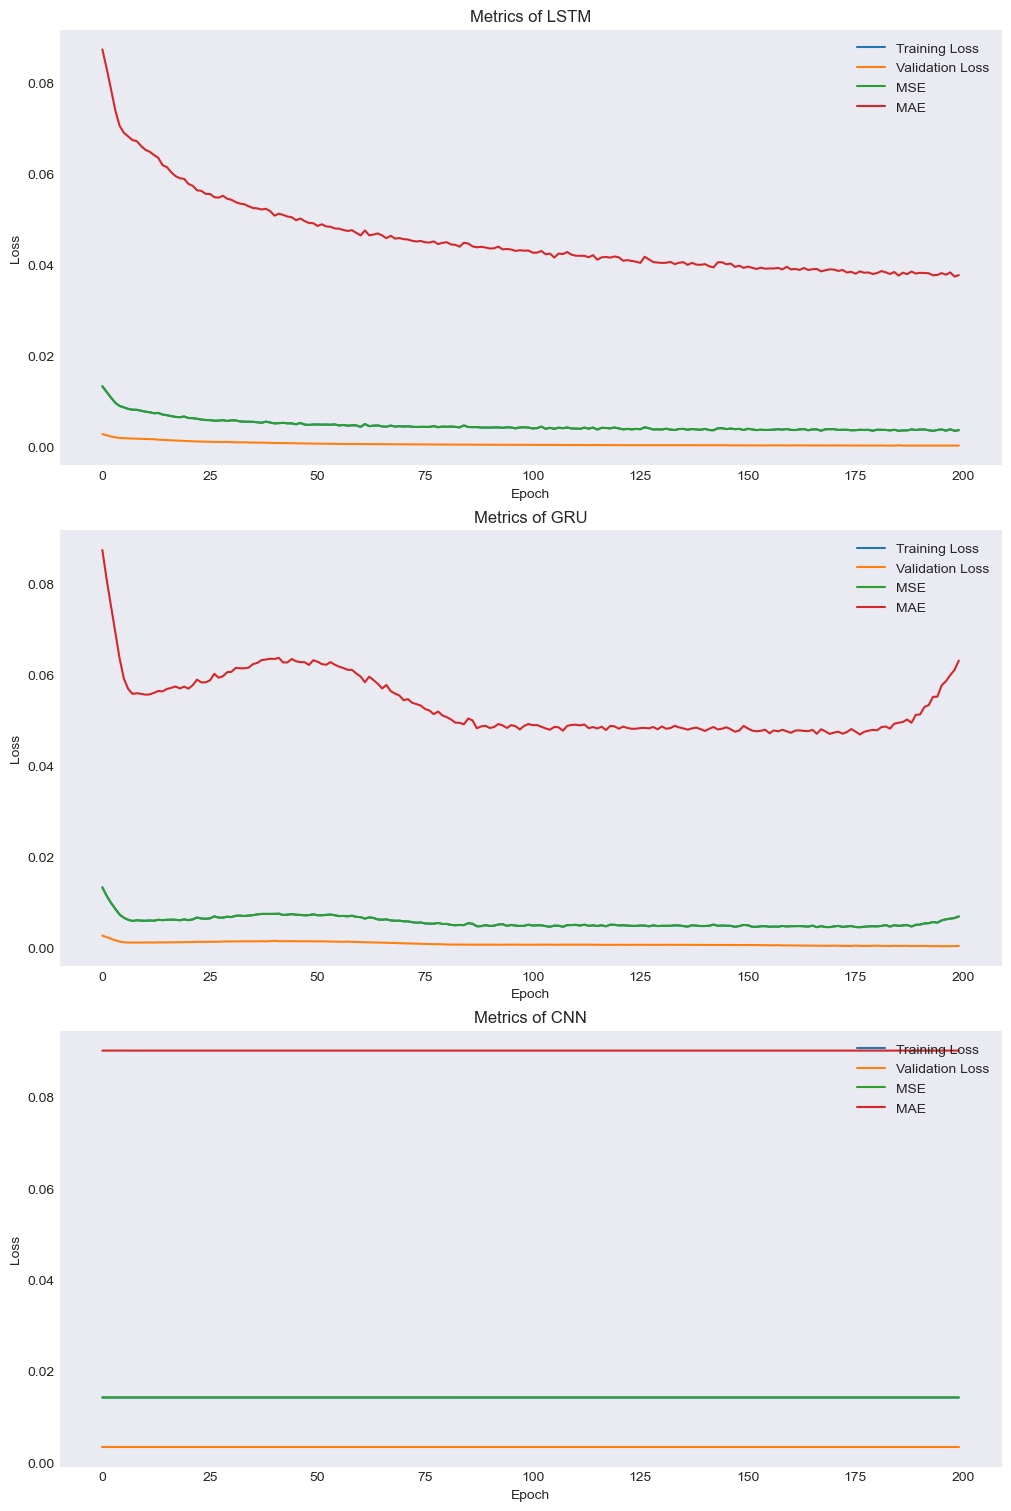

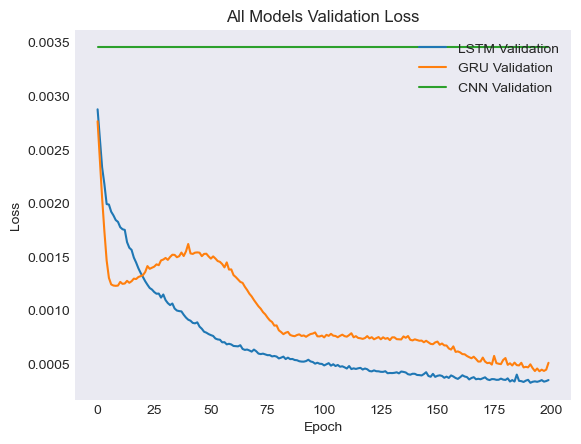

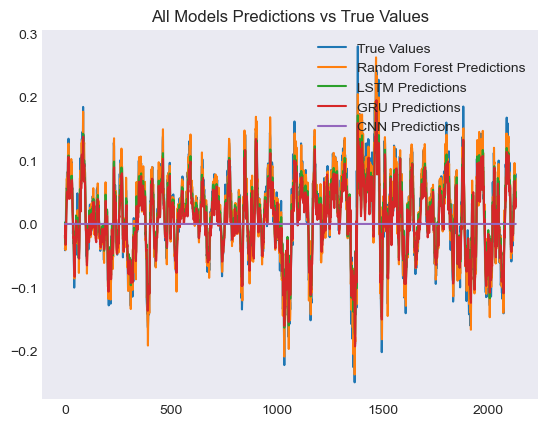

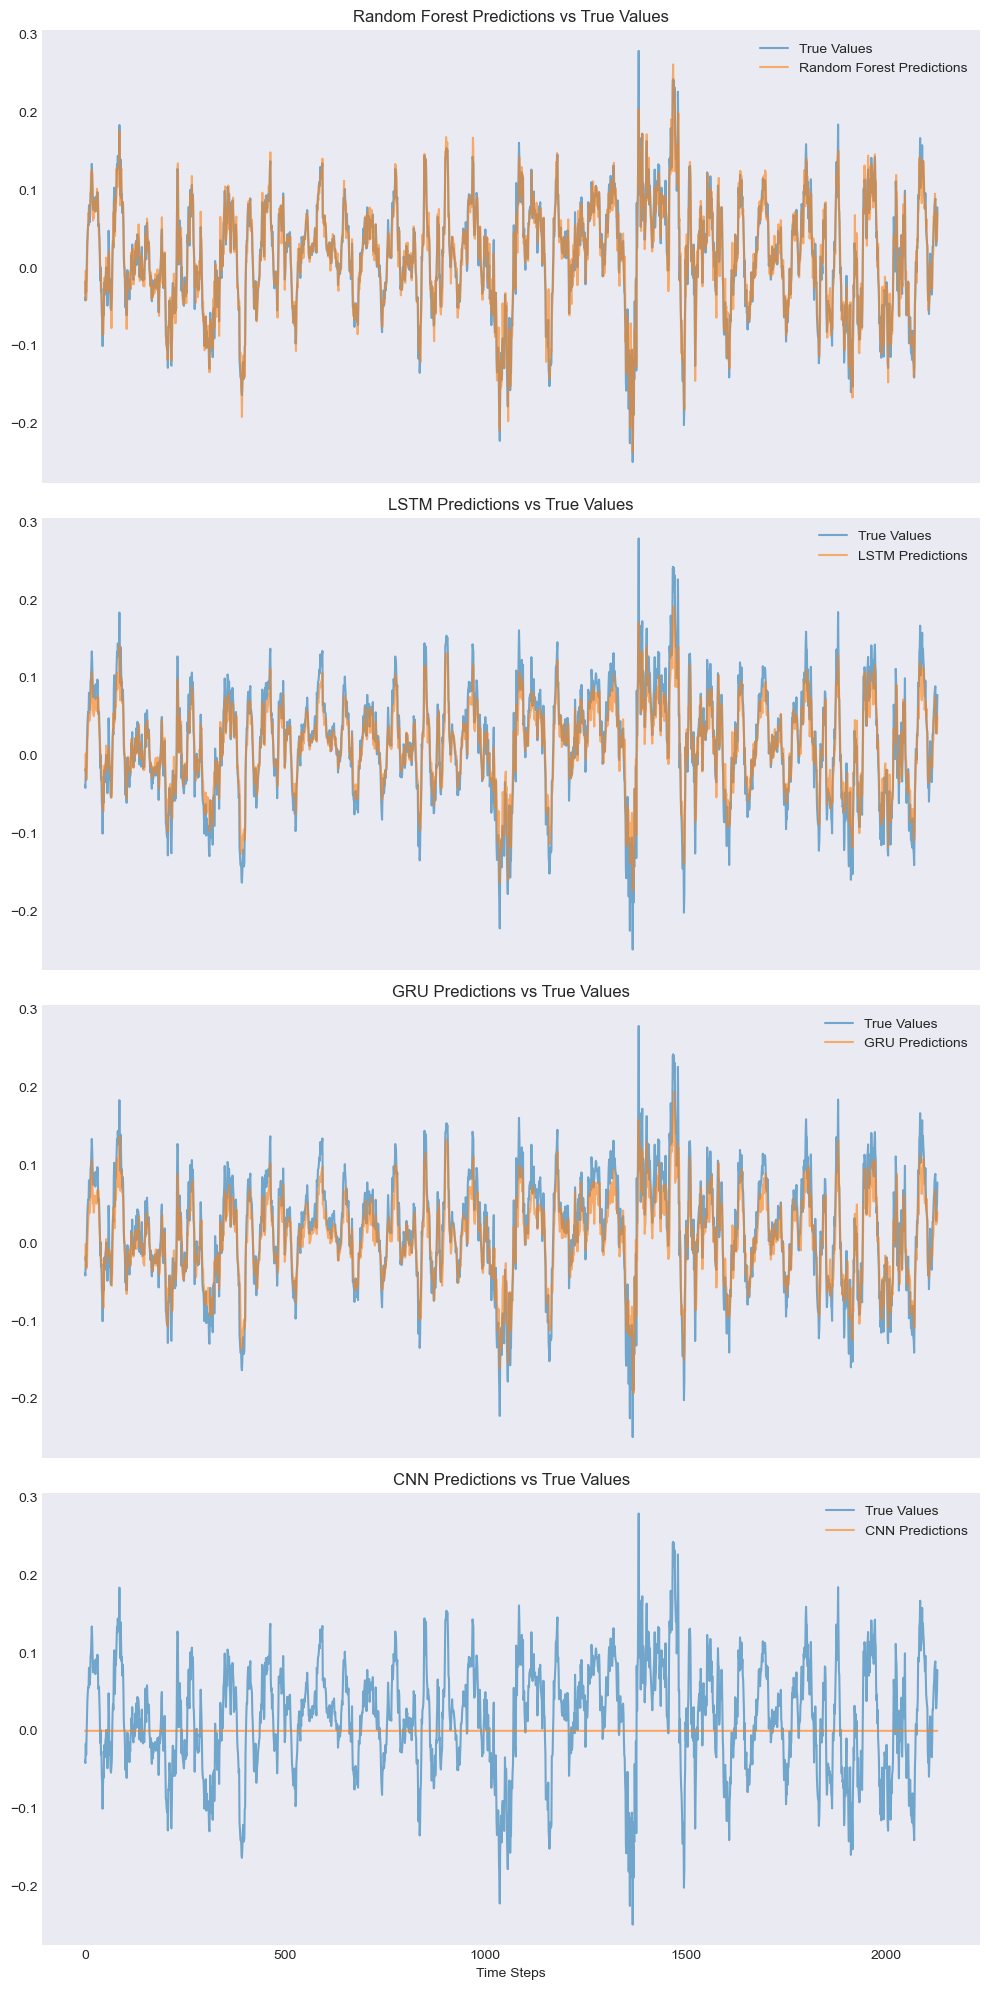

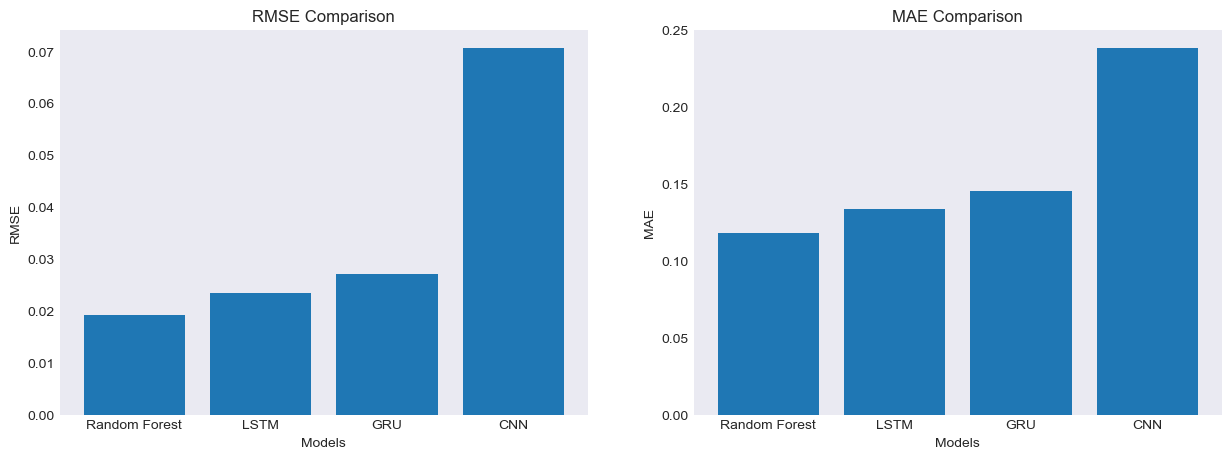

All Models and Root Mean Squared Error:
	Random Forest's RMSE is 0.0192
	LSTM's RMSE is 0.0235
	GRU's RMSE is 0.0270
	CNN's RMSE is 0.0707
The best model is Random Forest with an RMSE of 0.0192


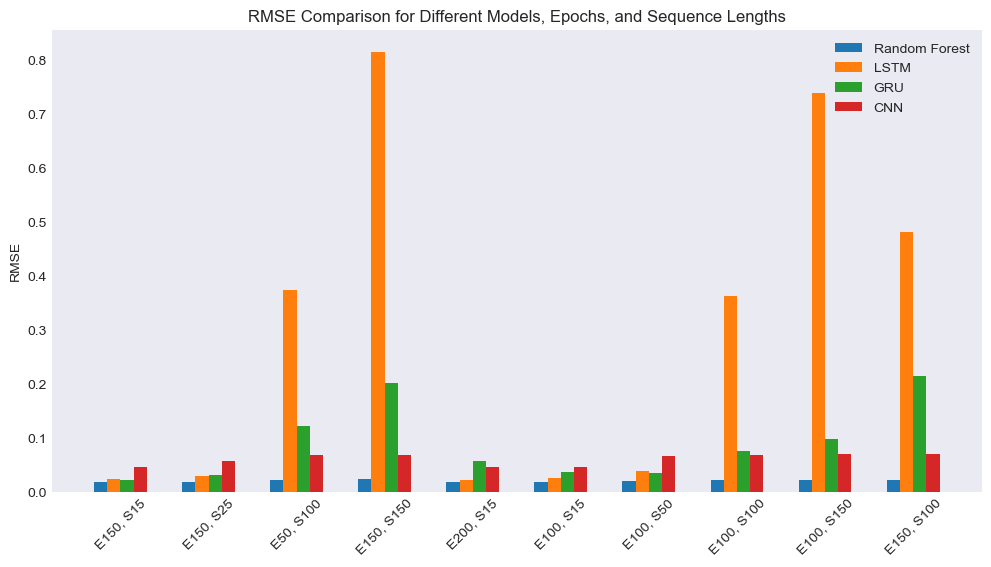

In [12]:


if __name__ == "__main__" :
	main( )
	get_metrics( )
	plot_and_save_metric_and_save( )
	get_final_good_model( )
